In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import nnls
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from scipy.sparse.linalg import cg
from joblib import Parallel, delayed

# MF SOLVER

In [88]:
class MF:
    def __init__(self):
        self.movielens = self.make_movielens()[:,:1000]
        self.nu , self.np = self.movielens.shape
        self.synthetic_full,self.synthetic_sparse = self.make_synthetic()

    def make_movielens(self):
        ratings = pd.read_csv("ml-latest-small/ml-latest-small/ratings.csv")

        user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
        user_item_matrix = user_item_matrix.fillna(np.nan).to_numpy()

        return user_item_matrix
    
    def make_synthetic(self):
        num_users, num_products = 500 , 4000
        rating_scale = (0, 5)  
        sparsity = 0.8  

        np.random.seed(42)
        R_full = np.random.uniform(low=rating_scale[0], high=rating_scale[1], size=(num_users, num_products))

        # Introduce sparsity
        mask = np.random.rand(*R_full.shape) > sparsity
        R_sparse = np.where(mask, R_full, np.nan)

        return R_full , R_sparse

    def parallel_methods(self , type , num_factors , num_iterations , lambda_reg , tol , R):
        num_users, num_items = R.shape
        P = np.random.rand(num_users, num_factors)
        Q = np.random.rand(num_items, num_factors)
        errors = []
        # Create a binary mask to indicate observed entries
        mask = ~np.isnan(R)

        prev_error = float('inf')
        def update_user(i):
            mask_i = mask[i, :]
            Q_i = Q[mask_i, :]
            R_i = R[i, mask_i]
            if type == 'cg':
                return cg(Q_i.T @ Q_i + lambda_reg * np.eye(num_factors), Q_i.T @ R_i)[0]
            elif type == 'nnls':
                return np.linalg.solve(Q_i.T @ Q_i + lambda_reg * np.eye(num_factors), Q_i.T @ R_i)[0]
        def update_item(j):
            mask_j = mask[:, j]
            P_j = P[mask_j, :]
            R_j = R[mask_j, j]
            return cg(P_j.T @ P_j + lambda_reg * np.eye(num_factors), P_j.T @ R_j)[0]
        
        # ALS
        for iteration in range(num_iterations):
            '''
            Parallel ALS using cg
            '''
            P = np.array(Parallel(n_jobs=-1)(delayed(update_user)(i) for i in range(num_users)))
            Q = np.array(Parallel(n_jobs=-1)(delayed(update_item)(j) for j in range(num_items)))


            R_pred = np.clip(P @ Q.T,0,5)
            error = np.sqrt(np.sum(((R[mask] - R_pred[mask]) ** 2)) / np.sum(mask))

            if iteration % 10 == 0: 
                print(f"Iteration {iteration + 1}/{num_iterations}, Error: {error:.6f}")

            # Check termination criteria
            if abs(prev_error - error) < tol:
                print(f"Iteration: {iteration}\n Error:{error:.6f} Convergence achieved!")
                break

            prev_error = error
            errors.append(prev_error)
        return P, Q, errors
    
    def sgd(self , num_factors , num_iterations , lambda_reg , tol, lr , R):
            mask = ~np.isnan(R)
            num_users, num_items = R.shape
            P = np.random.rand(num_users, num_factors)
            Q = np.random.rand(num_items, num_factors)
            errors = []
        
            for iteration in range(num_iterations):
                total_error = 0
                for u in range(num_users):
                    for i in range(num_users):
                        if not np.isnan(R[u,i]):
                            error = R[u,i] - P[u] @ (Q[i].T)
                            total_error += error**2

                            P[u] += lr * (error * Q[i] - lambda_reg * P[u])
                            Q[i] += lr * (error * P[u] - lambda_reg * Q[i])
                if total_error <= tol:
                    print(f'Converged at {iteration} rounds.')
                    break
                if iteration % 10 == 0:
                    print(f'Round {iteration} Error {total_error}')
                errors.append((total_error / mask.sum())**.5)

            return P, Q, errors

    def solve(self , method='cg' , data='synthetic' , num_factors=50 , num_iterations=100 , lambda_reg=0.1, tol=1e-6, lr=.01):
        '''
        method: str | chosen from ['cg' , 'nnls' , 'sgd']
        num_factors float 
        lambda_reg: float | regularization parameter
        tol: float | convergence tolarence
        lr: float | learning rate if using sgd
        '''
        if data == 'synthetic':
            R_full , R_sparse = self.synthetic_full , self.synthetic_sparse
            if method == 'cg' or 'nnls':
                return self.parallel_methods(method , num_factors , num_iterations , lambda_reg , tol , R_sparse) , R_full
            else:
                return self.sgd(num_factors , num_iterations , lambda_reg , tol, lr , R_sparse) , R_full
        elif data == 'movielens':
            R = self.movielens
            if method == 'cg' or 'nnls':
                return self.parallel_methods(method , num_factors , num_iterations , lambda_reg , tol , R)
            else:
                return self.sgd(num_factors , num_iterations , lambda_reg , tol, lr , R)

In [ ]:
mf_movies = MF()
res = mf_movies.solve(method='cg' , data='movielens' , num_factors=200 , num_iterations=100 , lambda_reg=0.1, tol=1e-6, lr=.1)


Iteration 1/100, Error: 0.061980
Iteration 11/100, Error: 0.026605
Iteration 21/100, Error: 0.020548
Iteration 31/100, Error: 0.017504
Iteration 41/100, Error: 0.015597
Iteration 51/100, Error: 0.014280
Iteration 61/100, Error: 0.013323
Iteration 71/100, Error: 0.012615
Iteration 81/100, Error: 0.012081
Iteration 91/100, Error: 0.011670


In [85]:
p,q,e = res#[0]
# f = res[1]

In [ ]:
res_nnls = mf_movies.solve(method='nnls' , data='movielens' , num_factors=200 , num_iterations=100 , lambda_reg=0.1, tol=1e-6, lr=.1)

Iteration 1/100, Error: 0.119502
Iteration 11/100, Error: 0.032394
Iteration 21/100, Error: 0.024740
Iteration 31/100, Error: 0.020917
Iteration 41/100, Error: 0.018505
Iteration 51/100, Error: 0.016833
Iteration 61/100, Error: 0.015628
Iteration 71/100, Error: 0.014724
Iteration 81/100, Error: 0.014017
Iteration 91/100, Error: 0.013460


In [90]:
p_nnls,q_nnls,e_nnls = res_nnls

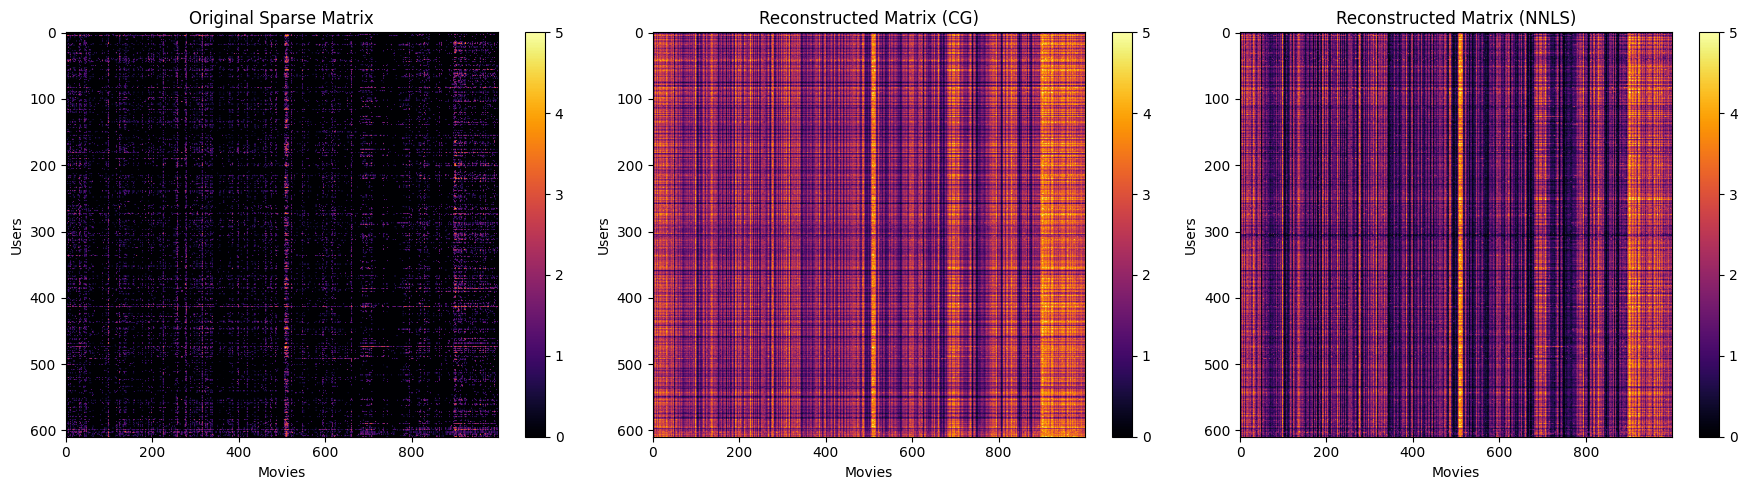

In [ ]:
def plot_multiple_matrices(matrices, titles=None, figsize=(6, 5)):
    """
    Plots multiple matrices side by side.
    
    Parameters:
    - matrices: List of 2D numpy arrays (matrices to plot).
    - titles: List of titles corresponding to each matrix. If None, default titles are used.
    - figsize: Tuple indicating the figure size (width, height).
    """
    n = len(matrices)  # Number of matrices to plot

    if titles is None:
        titles = [f"Matrix {i+1}" for i in range(n)]  # Default titles if not provided

    plt.figure(figsize=(figsize[0] * n, figsize[1] ))  # Adjust figure size dynamically
    
    for i, matrix in enumerate(matrices):
        plt.subplot(1, n, i + 1)  # Create subplot for each matrix
        plt.imshow(matrix, aspect='auto', cmap='inferno')
        plt.title(titles[i])
        plt.colorbar()
        plt.xlabel("Movies")
        plt.ylabel("Users")

    plt.tight_layout()
    plt.show()

original = np.nan_to_num(mf.movielens, nan=0)
R_clip = np.clip(p @ (q.T), 0, 5)
R_clip_ = np.clip(p_nnls @ (q_nnls.T), 0, 5)

plot_multiple_matrices(
    matrices=[original, R_clip , R_clip_],
    titles=["Original Sparse Matrix", "Reconstructed Matrix (CG)", "Reconstructed Matrix (NNLS)"]
)


In [ ]:
def calculate_match_percentage(matrix1, matrix2):
    """
    Calculate the percentage of matches between two matrices.
    A match is defined as both entries falling within the same range [N, N+1.5), 
    where N is an integer from 0 to 3.
    
    Parameters:
    - matrix1: First matrix (numpy array)
    - matrix2: Second matrix (numpy array)
    
    Returns:
    - Percentage of matches (float)
    """
    # Ensure both matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape!")
    
    # Calculate the range indices for each matrix
    ranges1 = np.floor(matrix1 / 1.5).astype(int)
    ranges2 = np.floor(matrix2 / 1.5).astype(int)
    
    # Apply the condition: both values must fall within [N, N+1.5)
    valid_ranges = (ranges1 >= 0) & (ranges1 <= 3) & (ranges2 >= 0) & (ranges2 <= 3)
    matches = (ranges1 == ranges2) & valid_ranges

    # Calculate match percentage
    total_valid = np.sum(valid_ranges)  # Total number of valid comparisons
    total_matches = np.sum(matches)    # Total number of matches

    if total_valid == 0:
        return 0.0  # Avoid division by zero
    
    return (total_matches / total_valid) * 100


match_percentage = calculate_match_percentage(R_clip, f)
print(f"Match Percentage: {match_percentage:.2f}%")


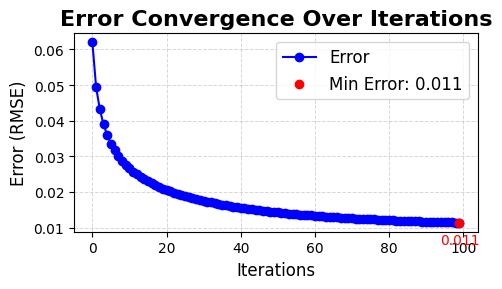

In [94]:
# Create the plot
plt.figure(figsize=(5, 3))
plt.plot(range(len(e)), e, marker='o', linestyle='-', color='blue', label='Error')

# Add title and labels
plt.title("Error Convergence Over Iterations", fontsize=16, fontweight='bold')
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Error (RMSE)", fontsize=12)

# Highlight the minimum error
min_error_idx = e.index(min(e))
plt.scatter(min_error_idx, e[min_error_idx], color='red', zorder=5, label=f'Min Error: {e[min_error_idx]:.3f}')
plt.annotate(f"{e[min_error_idx]:.3f}", (min_error_idx, e[min_error_idx]),
             textcoords="offset points", xytext=(0, -15), ha='center', color='red', fontsize=10)

# Add grid, legend, and adjust styling
plt.grid(alpha=0.5, linestyle='--', linewidth=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

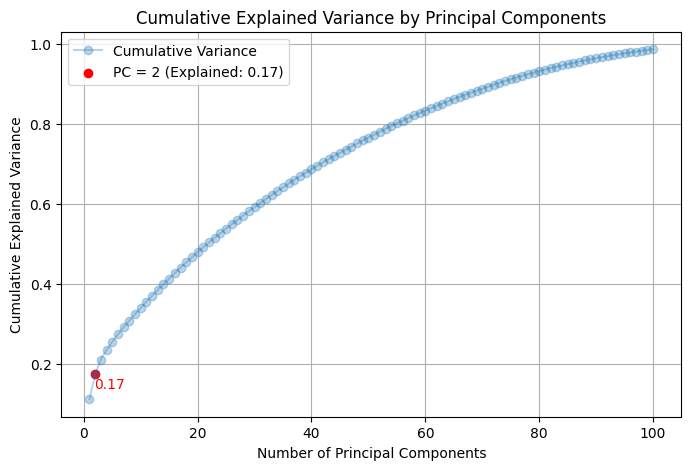

In [47]:
# Apply PCA to latent vectors
pca = PCA(n_components=100)  # Adjust to fit the number of features
pca.fit(P)  # Replace P with Q for item latent factors

# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 101), cumulative_variance, marker='o', alpha=0.3, label="Cumulative Variance")

# Highlight the point where number of components = 2
x_highlight = 2
y_highlight = cumulative_variance[x_highlight - 1]  # Index is 1-based for components

plt.scatter(x_highlight, y_highlight, color='red', label=f"PC = {x_highlight} (Explained: {y_highlight:.2f})")

# Add annotations
plt.annotate(
    f"{y_highlight:.2f}",
    (x_highlight, y_highlight),
    textcoords="offset points",
    xytext=(10, -10),
    ha='center',
    color='red'
)

# Add titles and labels
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.show()



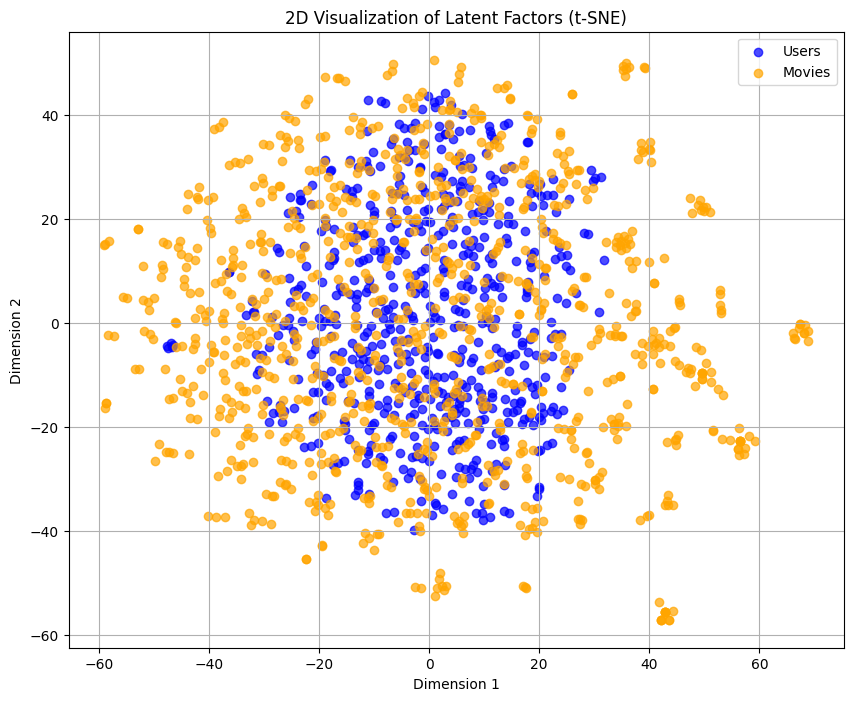

In [46]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
reduced_P = tsne.fit_transform(P)  # User latent factors
reduced_Q = tsne.fit_transform(Q)  # Item latent factors

# Plot latent factors in 2D
plt.figure(figsize=(10, 8))
plt.scatter(reduced_P[:, 0], reduced_P[:, 1], alpha=0.7, label="Users", c='blue')
plt.scatter(reduced_Q[:, 0], reduced_Q[:, 1], alpha=0.7, label="Movies", c='orange')

plt.title("2D Visualization of Latent Factors (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

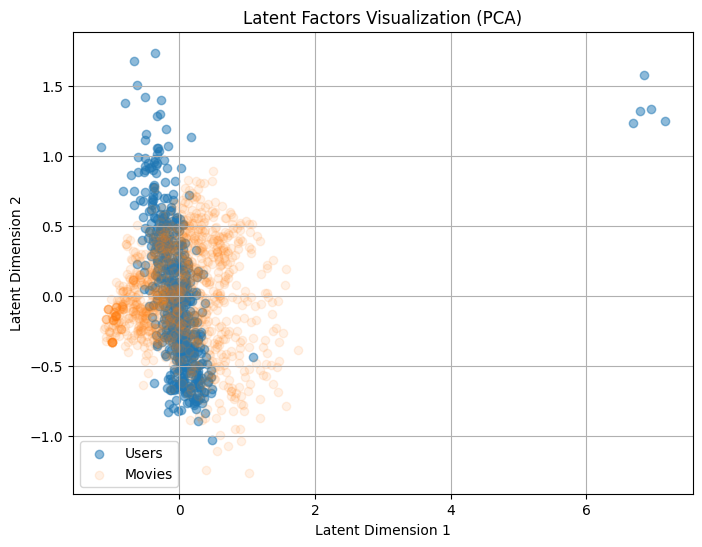

In [45]:

# Reduce latent dimensions for visualization
pca = PCA(n_components=2)
reduced_P = pca.fit_transform(P)  # User latent factors
reduced_Q = pca.fit_transform(Q)  # Movie latent factors

# Plot latent factors
plt.figure(figsize=(8, 6))
plt.scatter(reduced_P[:, 0], reduced_P[:, 1], label="Users", alpha=0.5)
plt.scatter(reduced_Q[:, 0], reduced_Q[:, 1], label="Movies", alpha=0.1)
plt.title("Latent Factors Visualization (PCA)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Reduce user (P) and item (Q) latent factors to 3 dimensions
pca = PCA(n_components=3)
reduced_P = pca.fit_transform(P)  # User latent factors
reduced_Q = pca.fit_transform(Q)  # Item latent factors

# Combine data into a single DataFrame for visualization
user_data = pd.DataFrame(reduced_P, columns=["Dim1", "Dim2", "Dim3"])
user_data["Type"] = "User"  # Label as users

movie_data = pd.DataFrame(reduced_Q, columns=["Dim1", "Dim2", "Dim3"])
movie_data["Type"] = "Movie"  # Label as movies

# Combine users and movies
combined_data = pd.concat([user_data, movie_data], ignore_index=True)

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    combined_data,
    x="Dim1",
    y="Dim2",
    z="Dim3",
    color="Type",  # Different colors for users and movies
    opacity=0.7,
    title="Interactive 3D Visualization of Latent Factors",
    labels={"Type": "Entity Type"}
)

# Show the interactive plot
fig.show()
